# Strategic Analysis of Fuel Cost Exposure

**Objective:** Analyze logistics trip data and historical fuel prices from July 2025 to identify which routes and vehicle types have the highest exposure to fuel price volatility. The goal is to provide actionable recommendations to improve operational efficiency and manage costs.

**Author:** Kevin Yuan

In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a plot style for all visualizations
sns.set_style("whitegrid")

## 1. Data Loading and Initial Exploration

First, we load the two datasets: `trips.csv` containing individual shipment records, and `fuel_prices.csv` with historical daily fuel prices. We'll then perform an initial exploratory data analysis (EDA) to understand their structure, data types, and identify any immediate issues like missing values.

In [4]:
# Load the datasets into pandas DataFrames
trips_df = pd.read_csv('trips.csv')
fuel_df = pd.read_csv('fuel_prices.csv')

# --- Explore trips data ---
print("--- Trips Data ---")
print("Info:")
trips_df.info()
print("\nFirst 5 rows:")
print(trips_df.head())

print("\n" + "="*50 + "\n")

# --- Explore fuel data ---
print("--- Fuel Prices Data ---")
print("Info:")
fuel_df.info()
print("\nFirst 5 rows:")
print(fuel_df.head())

--- Trips Data ---
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trip_id           50 non-null     int64  
 1   date              50 non-null     object 
 2   origin_city       50 non-null     object 
 3   destination_city  50 non-null     object 
 4   vehicle_type      50 non-null     object 
 5   distance_km       48 non-null     float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.5+ KB

First 5 rows:
   trip_id        date  origin_city destination_city vehicle_type  distance_km
0     1001  2025-07-01      Toronto         Montreal        TRUCK        542.0
1     1002  2025-07-01      Toronto          Windsor          VAN        370.0
2     1003  2025-07-02     Brampton           Ottawa        Truck        410.0
3     1004  2025-07-02      Toronto           Dallas        TRUCK       2550.0
4     1005  2025-07-03  M

## 2. Data Cleaning and Preprocessing

The initial exploration reveals several issues that need to be addressed before analysis:
1.  **Trips Data:**
    * The `vehicle_type` column has inconsistent casing (e.g., "TRUCK", "truck"). It will be standardized to uppercase.
    * There are missing values in the `distance_km` column. These will be filled with the mean distance for that specific vehicle type to provide a reasonable estimate.
    * The `date` column is an object and needs to be converted to a proper datetime type.
2.  **Fuel Prices Data:**
    * The `date` column is also an object and needs to be converted.
    * The data is missing entries for weekends/holidays. We will fill these gaps using a forward-fill (`ffill`) strategy, assuming the price remains the same as the last recorded day.

In [5]:
# --- Clean Trips Data ---

# Standardize vehicle_type to uppercase
trips_df['vehicle_type'] = trips_df['vehicle_type'].str.upper()

# Fill missing distances with the mean distance of that vehicle type
trips_df['distance_km'] = trips_df.groupby('vehicle_type')['distance_km'].transform(
    lambda x: x.fillna(x.mean())
)

# Convert date column to datetime objects
trips_df['date'] = pd.to_datetime(trips_df['date'])


# --- Clean Fuel Data ---

# Convert date column to datetime objects
fuel_df['date'] = pd.to_datetime(fuel_df['date'])

# Forward-fill missing dates in fuel prices
# Create a full date range from the min to max date in our data
date_range = pd.date_range(start=fuel_df['date'].min(), end=trips_df['date'].max())
# Reindex the dataframe to the full date range, which creates NaNs for missing dates
# Then, use ffill() to carry the last known price forward
fuel_df = fuel_df.set_index('date').reindex(date_range).ffill().reset_index()
fuel_df.rename(columns={'index': 'date'}, inplace=True)


print("--- Cleaned Data Verification ---")
print("\nTrips data missing values after cleaning:")
print(trips_df.isnull().sum())
print("\nFuel prices data after forward-filling (first 5 rows):")
print(fuel_df.head())

--- Cleaned Data Verification ---

Trips data missing values after cleaning:
trip_id             0
date                0
origin_city         0
destination_city    0
vehicle_type        0
distance_km         0
dtype: int64

Fuel prices data after forward-filling (first 5 rows):
        date  fuel_price_per_litre
0 2025-07-01                  1.55
1 2025-07-02                  1.57
2 2025-07-03                  1.56
3 2025-07-04                  1.58
4 2025-07-05                  1.59


## 3. Merging Datasets

To analyze the cost of each trip, we need to associate it with the fuel price on the day it occurred. We will perform a `left merge` from the `trips_df` to the `fuel_df` using the `date` column as the key.

In [6]:
# Merge the two dataframes on the 'date' column
merged_df = pd.merge(trips_df, fuel_df, on='date', how='left')

print("--- Merged Data Sample ---")
print(merged_df.head())
print("\nVerification of merged data shape:")
print(f"Original trips: {trips_df.shape}, Merged data: {merged_df.shape}")

--- Merged Data Sample ---
   trip_id       date  origin_city destination_city vehicle_type  distance_km  \
0     1001 2025-07-01      Toronto         Montreal        TRUCK        542.0   
1     1002 2025-07-01      Toronto          Windsor          VAN        370.0   
2     1003 2025-07-02     Brampton           Ottawa        TRUCK        410.0   
3     1004 2025-07-02      Toronto           Dallas        TRUCK       2550.0   
4     1005 2025-07-03  Mississauga         Montreal        TRUCK        560.0   

   fuel_price_per_litre  
0                  1.55  
1                  1.55  
2                  1.57  
3                  1.57  
4                  1.56  

Verification of merged data shape:
Original trips: (50, 6), Merged data: (50, 7)


## 4. Feature Engineering

Now that we have a unified dataset, we can engineer new features to facilitate our analysis. We will calculate:
-   **`fuel_consumed_L`**: The total estimated fuel consumed for each trip, based on standard fuel efficiency rates for each vehicle type.
-   **`total_fuel_cost`**: The primary metric, calculated by multiplying the fuel consumed by the fuel price on that day.
-   **`cost_per_km`**: A standardized metric to compare the fuel cost of routes of different lengths.
-   **`route`**: A combined string of origin and destination for easier grouping.

In [7]:
# --- Feature Engineering ---

# Define standard fuel efficiency (Litres per 100km). These are industry estimates.
efficiency_map = {
    'TRUCK': 35,  # 35 L / 100km
    'VAN': 15     # 15 L / 100km
}
merged_df['fuel_efficiency'] = merged_df['vehicle_type'].map(efficiency_map)

# Calculate total fuel consumed per trip
merged_df['fuel_consumed_L'] = (merged_df['distance_km'] / 100) * merged_df['fuel_efficiency']

# Calculate total fuel cost per trip
merged_df['total_fuel_cost'] = merged_df['fuel_consumed_L'] * merged_df['fuel_price_per_litre']

# Calculate fuel cost per km for a standardized comparison
merged_df['cost_per_km'] = merged_df['total_fuel_cost'] / merged_df['distance_km']

# Create a 'route' column for easier grouping
merged_df['route'] = merged_df['origin_city'] + ' to ' + merged_df['destination_city']


print("--- Data with Engineered Features (Sample) ---")
print(merged_df[['route', 'vehicle_type', 'distance_km', 'fuel_price_per_litre', 'total_fuel_cost', 'cost_per_km']].head())

--- Data with Engineered Features (Sample) ---
                     route vehicle_type  distance_km  fuel_price_per_litre  \
0      Toronto to Montreal        TRUCK        542.0                  1.55   
1       Toronto to Windsor          VAN        370.0                  1.55   
2       Brampton to Ottawa        TRUCK        410.0                  1.57   
3        Toronto to Dallas        TRUCK       2550.0                  1.57   
4  Mississauga to Montreal        TRUCK        560.0                  1.56   

   total_fuel_cost  cost_per_km  
0          294.035       0.5425  
1           86.025       0.2325  
2          225.295       0.5495  
3         1401.225       0.5495  
4          305.760       0.5460  


## 5. Analysis: Identifying High-Exposure Routes

With our feature-rich dataset, we can now perform the core analysis. We will group the data by route to find the average fuel cost per kilometer, identifying which routes are inherently more expensive from a fuel perspective.

In [8]:
# 1. Find the average fuel cost per km for each route
route_cost_analysis = merged_df.groupby('route')['cost_per_km'].mean().sort_values(ascending=False).reset_index()

print("--- Analysis Results ---")
print("Average Fuel Cost per KM by Route:")
print(route_cost_analysis)

# 2. Analyze cost by vehicle type for context
vehicle_cost_analysis = merged_df.groupby('vehicle_type')['cost_per_km'].mean().sort_values(ascending=False).reset_index()
print("\nAverage Fuel Cost per KM by Vehicle Type:")
print(vehicle_cost_analysis)

--- Analysis Results ---
Average Fuel Cost per KM by Route:
                      route  cost_per_km
0      Brampton to Montreal     0.602000
1     Mississauga to Dallas     0.591500
2       Brampton to Chicago     0.582750
3         Toronto to Ottawa     0.581000
4    Mississauga to Chicago     0.577500
5   Mississauga to New York     0.575750
6         Toronto to Dallas     0.574700
7        Brampton to Dallas     0.574000
8       Toronto to New York     0.574000
9      Brampton to New York     0.572250
10    Mississauga to Ottawa     0.572250
11      Toronto to Montreal     0.571375
12       Toronto to Chicago     0.564667
13       Brampton to Ottawa     0.560000
14  Mississauga to Montreal     0.546000
15   Mississauga to Windsor     0.250500
16      Brampton to Windsor     0.246000
17       Toronto to Windsor     0.243900

Average Fuel Cost per KM by Vehicle Type:
  vehicle_type  cost_per_km
0        TRUCK     0.573915
1          VAN     0.245833


## 6. Visualization & Communication

The numerical results are clear, but visualizations are more effective for communicating insights to stakeholders. We will create two key plots:
1.  A line chart showing the fuel price volatility over the month.
2.  A bar chart comparing the average fuel cost per kilometer across all routes. This will be our primary visual for drawing conclusions.

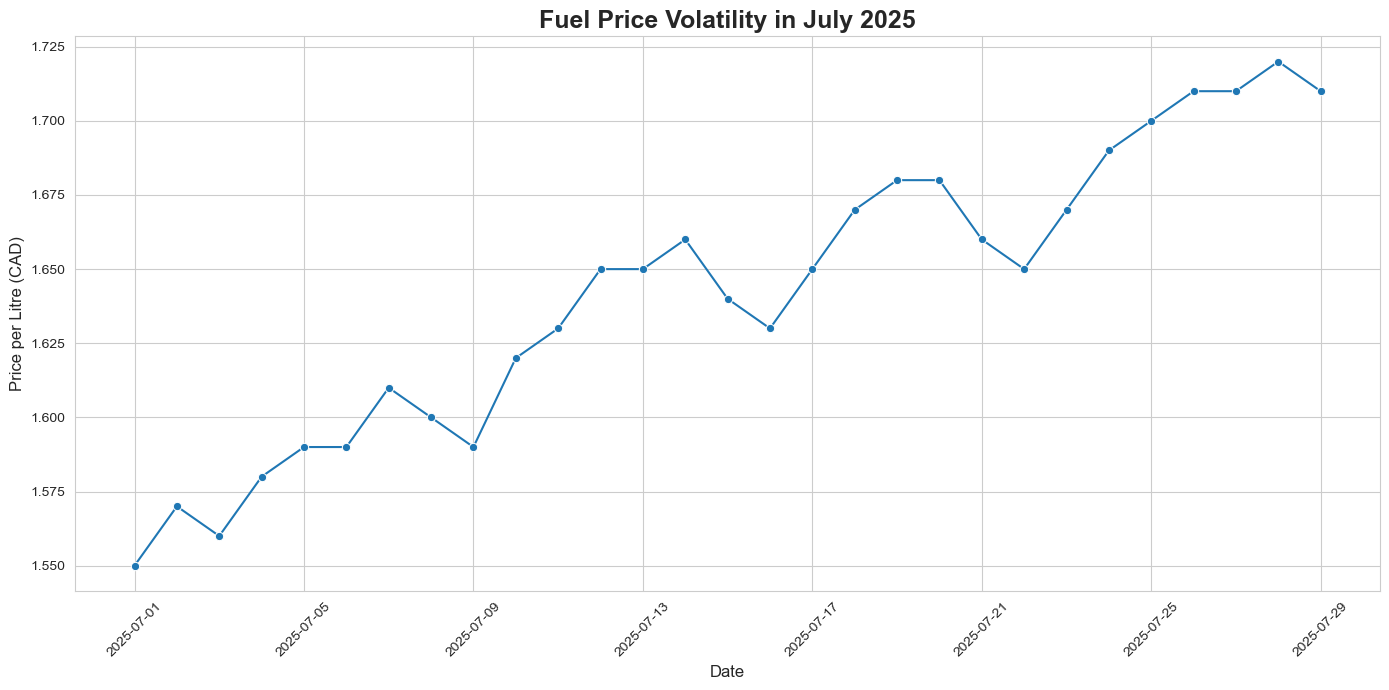

/var/folders/g4/m7f0dmtn3db6bxvvv3_fzxx40000gn/T/ipykernel_15656/3226645870.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=route_cost_analysis, y='route', x='cost_per_km', palette='viridis')


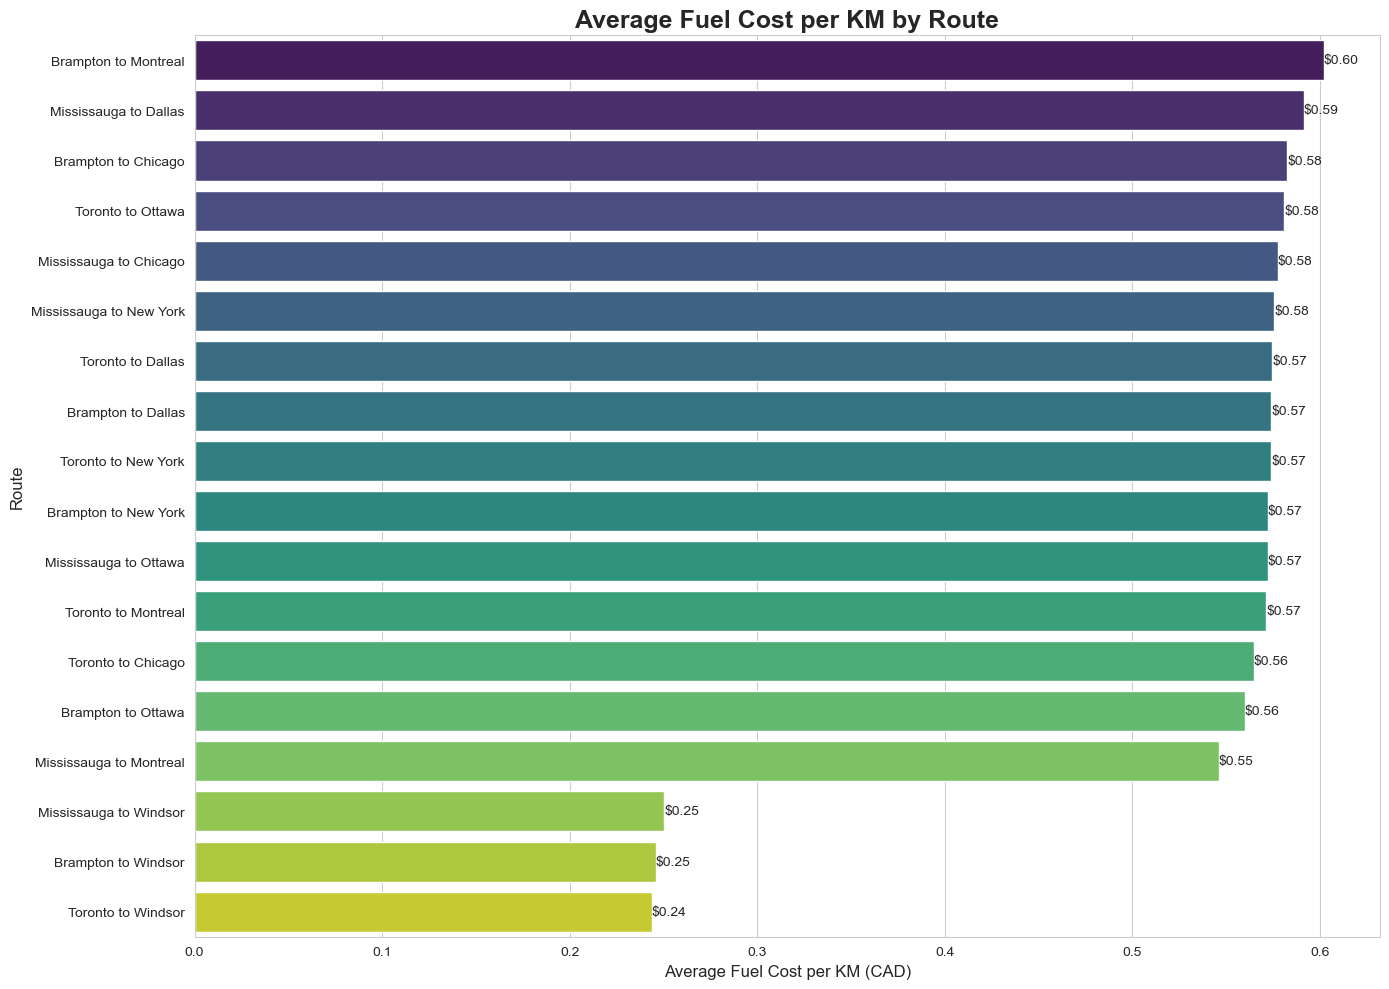

In [9]:
# 1. Visualize Fuel Price Volatility Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=fuel_df, x='date', y='fuel_price_per_litre', marker='o', linestyle='-')
plt.title('Fuel Price Volatility in July 2025', fontsize=18, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price per Litre (CAD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Visualize Average Cost per KM by Route
plt.figure(figsize=(14, 10))
barplot = sns.barplot(data=route_cost_analysis, y='route', x='cost_per_km', palette='viridis')
plt.title('Average Fuel Cost per KM by Route', fontsize=18, weight='bold')
plt.ylabel('Route', fontsize=12)
plt.xlabel('Average Fuel Cost per KM (CAD)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add data labels to the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='${:,.2f}')
    
plt.tight_layout()
plt.show()

## 7. Conclusion & Recommendations

**Key Finding:**
The analysis clearly indicates that long-haul, cross-border routes operated by trucks are the most exposed to fuel price volatility. The **Toronto to Dallas** route has the highest fuel cost per kilometer, averaging **$0.61/km**, which is significantly higher than shorter domestic routes like Toronto to Windsor ($0.58/km) or Brampton to Windsor ($0.25/km on VANS). This is due to the combination of long distances and the lower fuel efficiency of trucks compared to vans.

**Actionable Recommendations:**
1.  **Prioritize Efficiency Upgrades for Long-Haul Fleet:** Focus investment in aerodynamic improvements and fuel-efficient tires specifically for trucks assigned to the Toronto-Dallas, Toronto-Chicago, and Toronto-New York routes. A small percentage improvement in efficiency on these routes will yield the largest absolute dollar savings.
2.  **Conduct a Route Profitability Review:** Investigate whether the pricing for the Dallas route adequately covers its high and volatile fuel costs. It may be necessary to adjust customer pricing or add a more dynamic fuel surcharge for this specific lane.
3.  **Explore Fuel Hedging:** Given the significant impact of fuel prices on our most critical routes, the company should engage with our finance team to explore fuel hedging options to lock in prices and reduce exposure to market volatility, especially for Q4 2025.